# Misc

### Memory and CPU profiling

In [11]:
import psutil
import threading
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def monitor_usage(log, interval=0.1):
    try:
        while True:
            mem = psutil.virtual_memory().used / (1024 * 1024 * 1024)  # Convert to GB
            log.append((datetime.now(), mem))
            time.sleep(interval)
    except KeyboardInterrupt:
        pass

def monitor_and_run(func, args=(), kwargs={}, interval=0.1):
    # List to store (timestamp, memory_usage, cpu_usage)
    usage_log = []

    # Start the monitoring function in a separate thread
    monitor_thread = threading.Thread(target=monitor_usage, args=(usage_log, interval))
    monitor_thread.start()

    # Run the target function
    result = func(*args, **kwargs)

    # Stop the monitoring thread
    monitor_thread.join(timeout=0.5)  # Add timeout for clean exit if needed

    # Visualization
    timestamps, mem_usage = zip(*usage_log)
    plt.figure(figsize=(12, 6))

    plt.plot(timestamps, mem_usage, label='Memory Usage')
    plt.ylabel('Memory Usage (GB)')
    plt.title('Memory Usage Over Time')
    plt.legend()
    plt.grid(True)

    # Format x-axis as date-time
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=20))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

    return result


In [ ]:
## Usage

# Define a function to monitor
def my_func(stop):
    for i in range(stop):
        pass
    return 100

# Run the function with monitoring
result = monitor_and_run(my_func, kwargs={"stop":10000000})
print(result)

# Evaluation

### Supervised evaluation

Step 0: Do inference on the test set

Manual clustering

In [ ]:
test_umap_embeddings = topic_model.umap_model.transform(test_embeddings)
test_preds, _ = hdbscan.approximate_predict(topic_model.hdbscan_model,test_umap_embeddings)


In [ ]:

test_df['template_cluster'] = test_preds
test_df = test_df.drop(columns=["encoded_label_y"], axis=1)
test_df = test_df.rename(columns={"encoded_label_x": "encoded_label"})

In [41]:
test_predicted_topics, _ = topic_model.transform(documents=test_text_data, images=test_images, embeddings=test_embeddings)
test_df['template_cluster'] = test_predicted_topics

2024-04-29 10:16:00,118 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-04-29 10:18:15,978 - BERTopic - Dimensionality - Completed ✓
2024-04-29 10:18:15,980 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-04-29 10:19:28,954 - BERTopic - Cluster - Completed ✓


In [43]:
test_df.to_parquet(r"D:\Murgi\code\memes2024\meme-research-2024\data\touch\test_preds.parquet")

Step 1: Label Mapping to Clusters

In [130]:
def get_metrics(train_df, test_df):
    train_labels = train_df['encoded_label'].fillna(-1).values.tolist()
    train_labels_pred = train_df['predicted_label'].fillna(-1).values.tolist()

    # Filter only for kym samples
    kym_labels_indices = [index for index, label in enumerate(train_labels) if label != -1]

    # Filter only for non-outlier samples
    train_non_outlier_labels_indices = [index for index, label in enumerate(train_labels_pred) if label != -1]

    # Get intersection of kym samples and non-outlier samples
    kym_labels_indices = list(set(kym_labels_indices).intersection(set(train_non_outlier_labels_indices)))

    train_kym_labels = [train_labels[index] for index in kym_labels_indices]
    train_kym_labels_pred = [train_labels_pred[index] for index in kym_labels_indices]

    test_labels = test_df['encoded_label'].values.tolist()
    test_labels_pred = test_df['predicted_label'].values.tolist()

    # Filter only for non-outlier samples
    test_non_outlier_labels_indices = [index for index, label in enumerate(test_labels_pred) if label != -1]

    test_kym_labels = [test_labels[index] for index in test_non_outlier_labels_indices]
    test_kym_labels_pred = [test_labels_pred[index] for index in test_non_outlier_labels_indices]

    # Calculate metrics
    metrics = {}
    metrics['train'] = {}
    metrics['test'] = {}

    train_RI, train_ARI, train_HS, train_CS, train_V, train_FMI = calc_cluster_extrinsic(train_kym_labels, train_kym_labels_pred)
    test_RI, test_ARI, test_HS, test_CS, test_V, test_FMI = calc_cluster_extrinsic(test_kym_labels, test_kym_labels_pred)

    train_mcc, train_f1_macro, train_f1_micro, train_f1_weighted, train_kappa = calc_classification_metrics(train_kym_labels, train_kym_labels_pred)
    test_mcc, test_f1_macro, test_f1_micro, test_f1_weighted, test_kappa = calc_classification_metrics(test_kym_labels, test_kym_labels_pred)

    metrics['train']['RI'] = train_RI
    metrics['train']['ARI'] = train_ARI
    metrics['train']['HS'] = train_HS
    metrics['train']['CS'] = train_CS
    metrics['train']['V'] = train_V
    metrics['train']['FMI'] = train_FMI
    metrics['train']['mcc'] = train_mcc
    metrics['train']['f1_macro'] = train_f1_macro
    metrics['train']['f1_micro'] = train_f1_micro
    metrics['train']['f1_weighted'] = train_f1_weighted
    metrics['train']['kappa'] = train_kappa

    metrics['test']['RI'] = test_RI
    metrics['test']['ARI'] = test_ARI
    metrics['test']['HS'] = test_HS
    metrics['test']['CS'] = test_CS
    metrics['test']['V'] = test_V
    metrics['test']['FMI'] = test_FMI
    metrics['test']['mcc'] = test_mcc
    metrics['test']['f1_macro'] = test_f1_macro
    metrics['test']['f1_micro'] = test_f1_micro
    metrics['test']['f1_weighted'] = test_f1_weighted
    metrics['test']['kappa'] = test_kappa

    return metrics


In [133]:
folder = r"./output/image-only/"

clusterings = {}

for file in tqdm(os.listdir(folder), unit='clustering'):
    if file.endswith(".parquet"):
        df = pd.read_parquet(os.path.join(folder, file))
        train_df = df.loc[:1268789,:]
        test_df = df.loc[1268789:,:]
        metrics = get_metrics(train_df, test_df)
        clusterings[file] = metrics

  0%|          | 0/7 [00:00<?, ?clustering/s]

In [136]:
classification_data = []

for clustering, metrics in clusterings.items():
    # For training data
    classification_data.append({
        'Clustering': clustering,
        'Dataset': 'Train',
        'mcc': metrics['train']['mcc'],
        'kappa': metrics['train']['kappa'],
        'f1_micro': metrics['train']['f1_micro'],
        'f1_macro': metrics['train']['f1_macro'],
        'f1_weighted': metrics['train']['f1_weighted']
    })
    
    # For test data
    classification_data.append({
        'Clustering': clustering,
        'Dataset': 'Test',
        'mcc': metrics['test']['mcc'],
        'kappa': metrics['test']['kappa'],
        'f1_micro': metrics['test']['f1_micro'],
        'f1_macro': metrics['test']['f1_macro'],
        'f1_weighted': metrics['test']['f1_weighted']
    })

classification_df = pd.DataFrame(classification_data)

clustering_data = []

for clustering, metrics in clusterings.items():
    # For training data
    clustering_data.append({
        'Clustering': clustering,
        'Dataset': 'Train',
        'RI': metrics['train']['RI'],
        'ARI': metrics['train']['ARI'],
        'HS': metrics['train']['HS'],
        'CS': metrics['train']['CS'],
        'V': metrics['train']['V'],
        'FMI': metrics['train']['FMI']
    })
    
    # For test data
    clustering_data.append({
        'Clustering': clustering,
        'Dataset': 'Test',
        'RI': metrics['test']['RI'],
        'ARI': metrics['test']['ARI'],
        'HS': metrics['test']['HS'],
        'CS': metrics['test']['CS'],
        'V': metrics['test']['V'],
        'FMI': metrics['test']['FMI']
    })

clustering_df = pd.DataFrame(clustering_data)



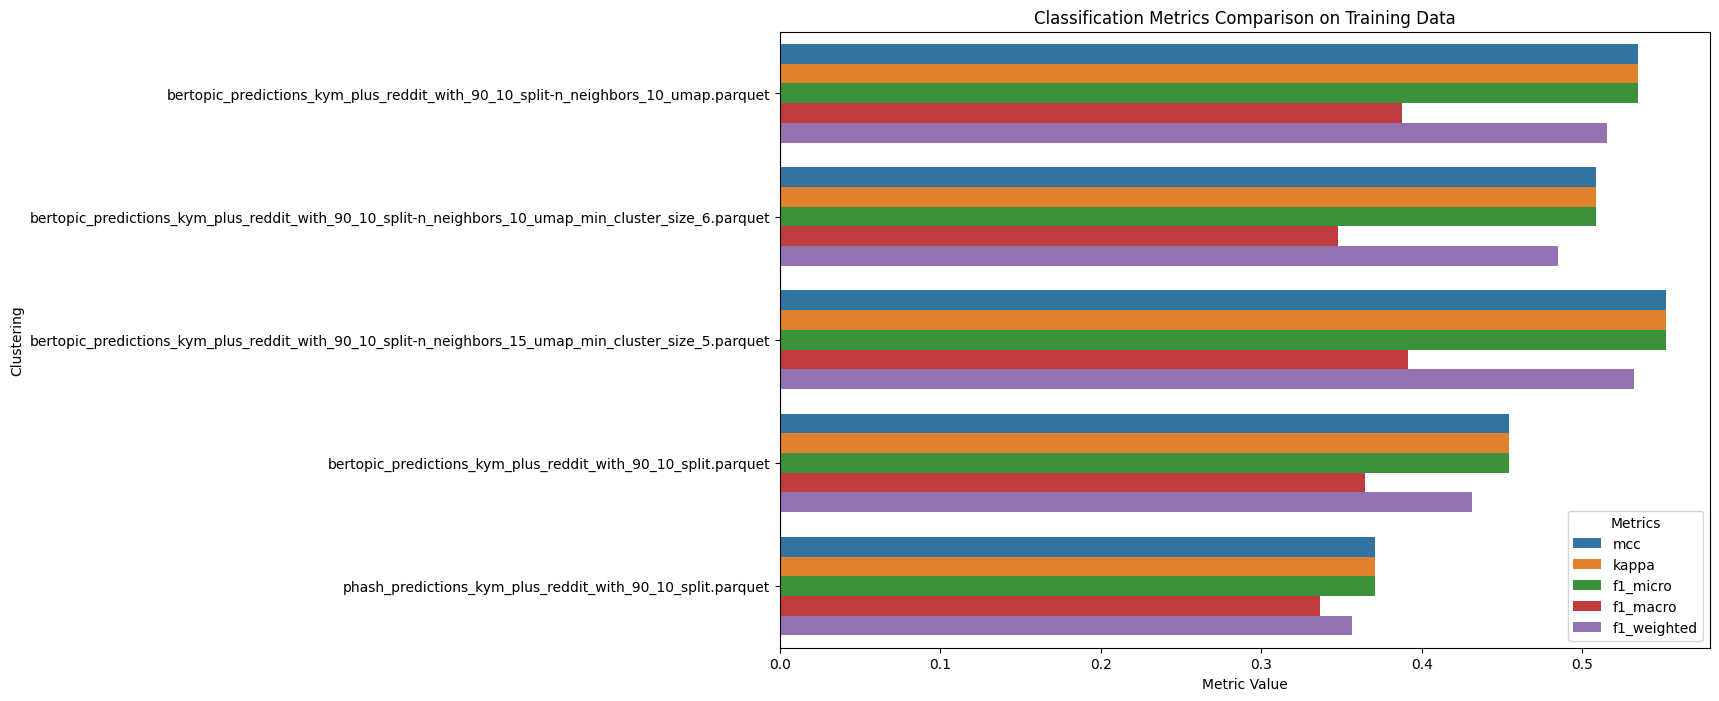

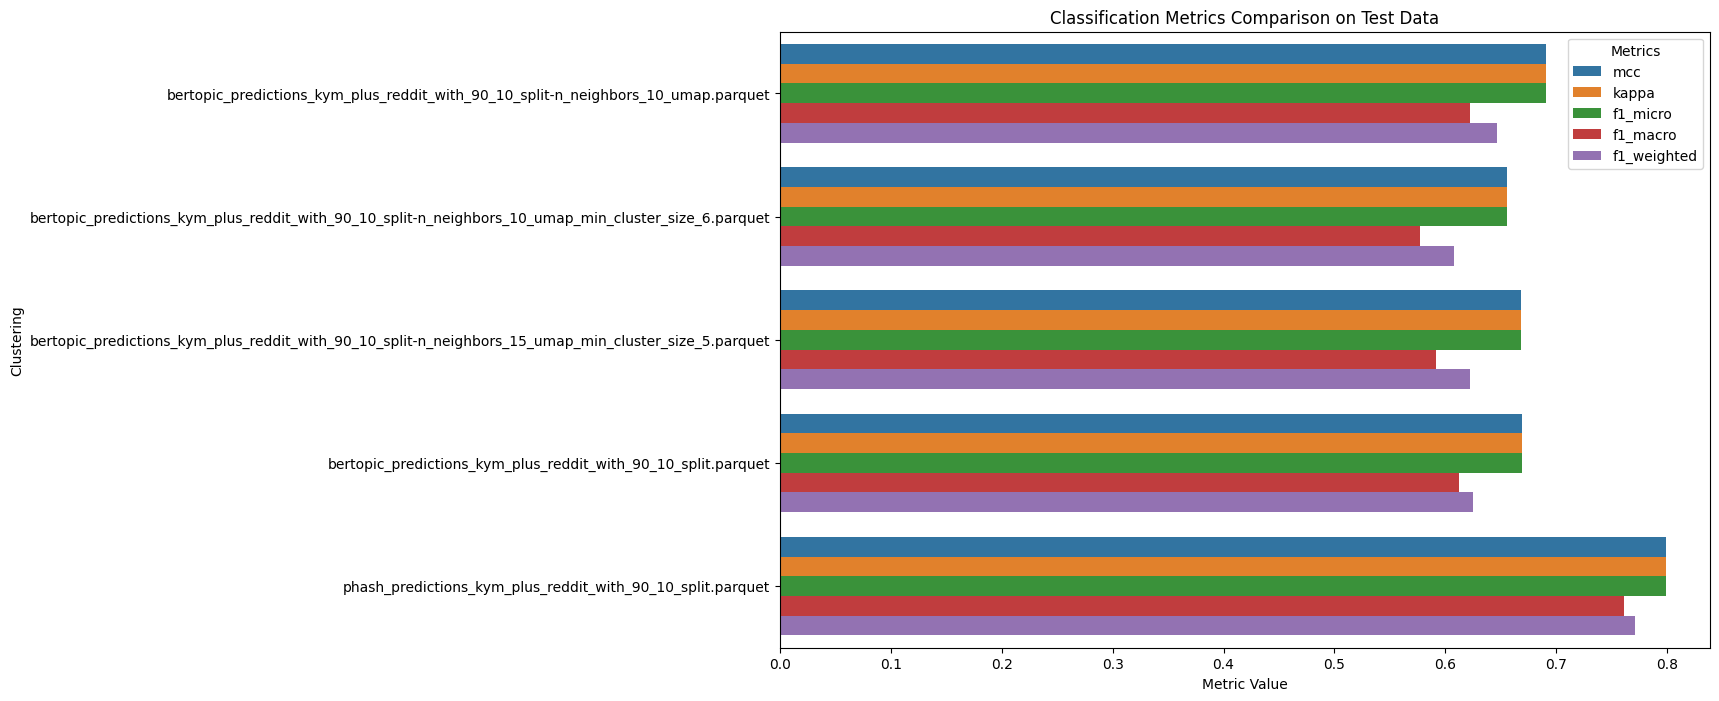

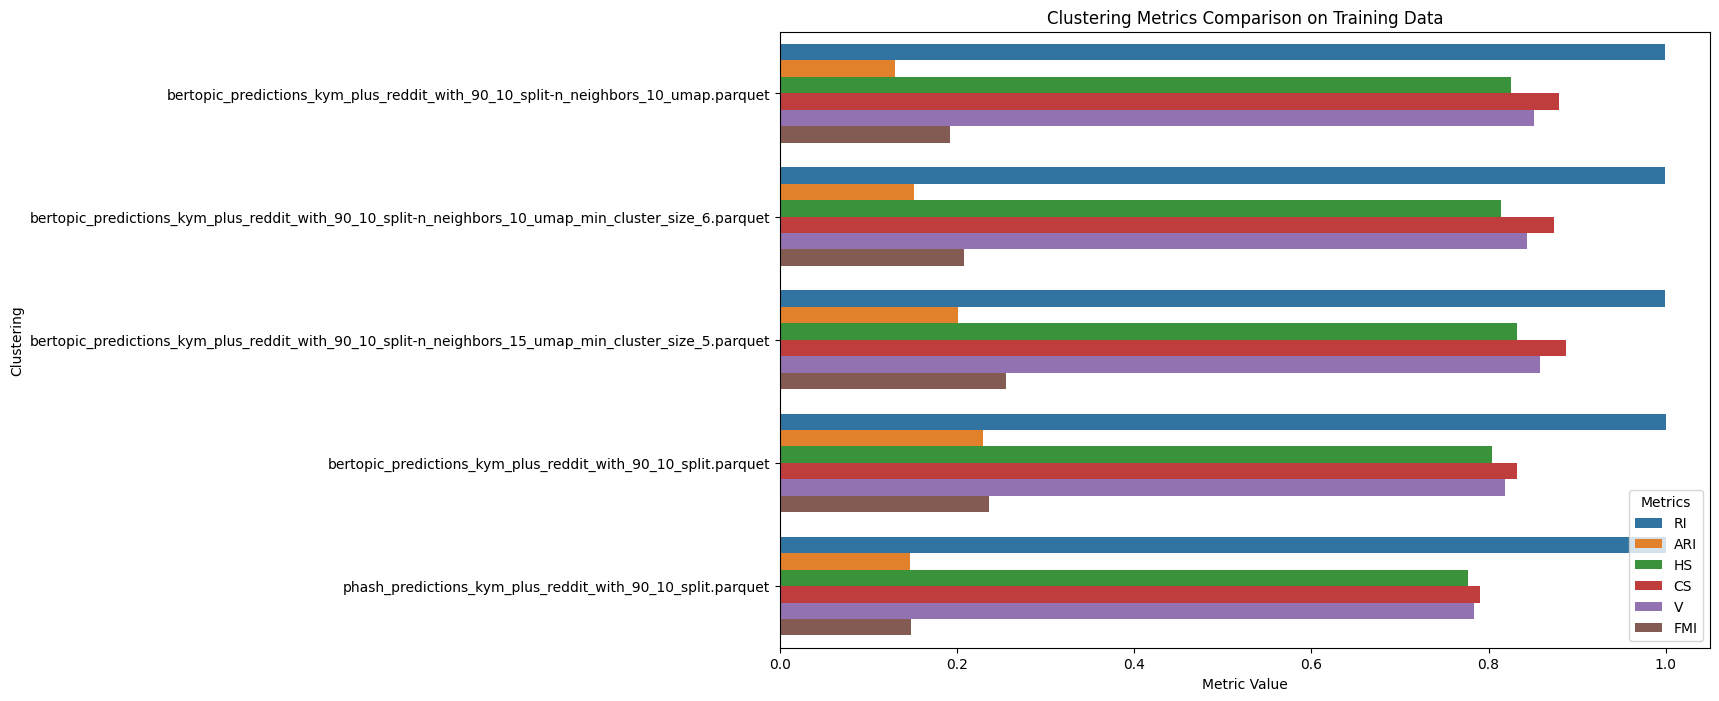

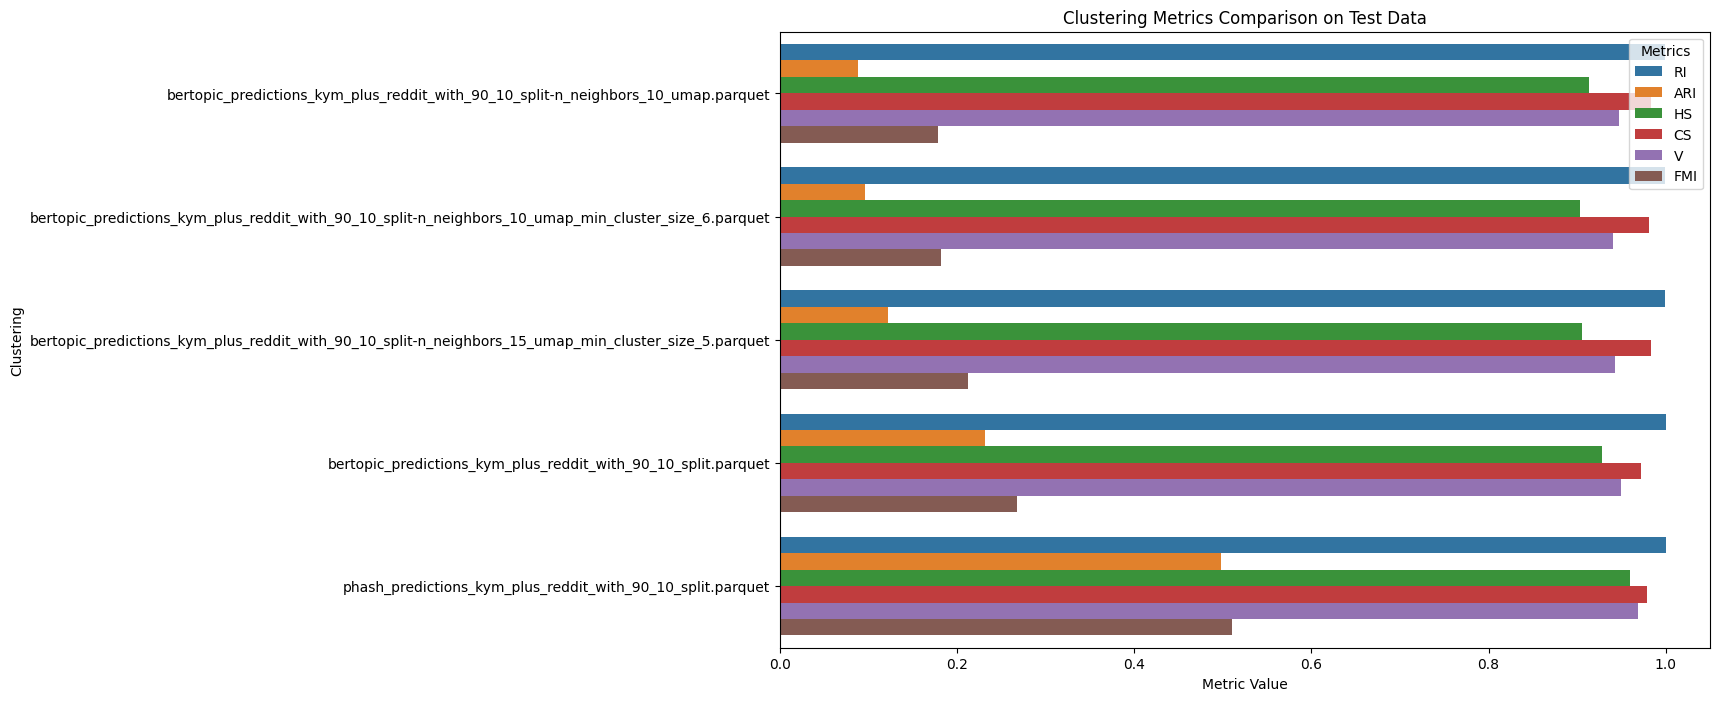

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(data=classification_df[classification_df['Dataset'] == 'Train'].melt(id_vars=['Clustering', 'Dataset']), x='value', y='Clustering', hue='variable')
plt.title('Classification Metrics Comparison on Training Data')
plt.xlabel('Metric Value')
plt.ylabel('Clustering')
plt.legend(title='Metrics')
plt.show()


plt.figure(figsize=(12, 8))
sns.barplot(data=classification_df[classification_df['Dataset'] == 'Test'].melt(id_vars=['Clustering', 'Dataset']), x='value', y='Clustering', hue='variable')
plt.title('Classification Metrics Comparison on Test Data')
plt.xlabel('Metric Value')
plt.ylabel('Clustering')
plt.legend(title='Metrics')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=clustering_df[clustering_df['Dataset'] == 'Train'].melt(id_vars=['Clustering', 'Dataset']), x='value', y='Clustering', hue='variable')
plt.title('Clustering Metrics Comparison on Training Data')
plt.xlabel('Metric Value')
plt.ylabel('Clustering')
plt.legend(title='Metrics')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=clustering_df[clustering_df['Dataset'] == 'Test'].melt(id_vars=['Clustering', 'Dataset']), x='value', y='Clustering', hue='variable')
plt.title('Clustering Metrics Comparison on Test Data')
plt.xlabel('Metric Value')
plt.ylabel('Clustering')
plt.legend(title='Metrics')
plt.show()


In [44]:
reduced_train_cluster_to_template = train_df.groupby('template_cluster')['template_id'].apply(list).to_dict()
reduced_test_cluster_to_template = test_df.groupby('template_cluster')['template_id'].apply(list).to_dict()
reduced_train_cluster_to_template

{-1: [989.0,
  984.0,
  555.0,
  411.0,
  864.0,
  235.0,
  41.0,
  538.0,
  860.0,
  498.0,
  35.0,
  1102.0,
  903.0,
  203.0,
  35.0,
  603.0,
  1056.0,
  407.0,
  660.0,
  694.0,
  1119.0,
  27.0,
  837.0,
  1083.0,
  50.0,
  933.0,
  864.0,
  58.0,
  698.0,
  864.0,
  342.0,
  69.0,
  194.0,
  992.0,
  798.0,
  584.0,
  691.0,
  352.0,
  1065.0,
  1114.0,
  670.0,
  863.0,
  409.0,
  1126.0,
  1002.0,
  599.0,
  69.0,
  1061.0,
  545.0,
  851.0,
  295.0,
  451.0,
  1080.0,
  816.0,
  537.0,
  550.0,
  532.0,
  1059.0,
  548.0,
  42.0,
  178.0,
  660.0,
  1064.0,
  453.0,
  1081.0,
  141.0,
  625.0,
  541.0,
  221.0,
  907.0,
  511.0,
  287.0,
  857.0,
  126.0,
  680.0,
  187.0,
  772.0,
  516.0,
  607.0,
  962.0,
  380.0,
  187.0,
  1116.0,
  860.0,
  43.0,
  599.0,
  1056.0,
  970.0,
  967.0,
  689.0,
  297.0,
  136.0,
  413.0,
  1055.0,
  162.0,
  1112.0,
  295.0,
  1004.0,
  535.0,
  958.0,
  524.0,
  943.0,
  535.0,
  725.0,
  1030.0,
  845.0,
  1121.0,
  493.0,
  806.0,
  879

In [45]:
# Drop -1 cluster as it is the outlier cluster
reduced_train_cluster_to_template.pop(-1)
reduced_test_cluster_to_template.pop(-1)

[32,
 156,
 58,
 286,
 491,
 474,
 229,
 213,
 58,
 961,
 186,
 1055,
 311,
 488,
 511,
 118,
 564,
 516,
 540,
 954,
 1076,
 472,
 1043,
 622,
 25,
 199,
 713,
 785,
 939,
 796,
 796,
 790,
 860,
 575,
 748,
 670,
 647,
 153,
 610,
 644,
 577,
 860,
 367,
 352,
 302,
 163,
 856,
 623,
 562,
 369,
 195,
 730,
 791,
 871,
 743,
 85,
 962,
 74,
 794,
 791,
 361,
 1133,
 387,
 540,
 402,
 234,
 230,
 99,
 599,
 599,
 665,
 1026,
 703,
 357,
 58,
 221,
 473,
 1117,
 82,
 940,
 369,
 424,
 19,
 843,
 578,
 124,
 913,
 170,
 131,
 1112,
 986,
 675,
 822,
 1132,
 138,
 339,
 165,
 484,
 653,
 785,
 135,
 665,
 515,
 239,
 1102,
 600,
 538,
 487,
 456,
 1,
 1005,
 131,
 949,
 919,
 93,
 118,
 229,
 1081,
 452,
 992,
 816,
 718,
 896,
 1005,
 314,
 23,
 658,
 582,
 214,
 351,
 862,
 511,
 638,
 337,
 560,
 114,
 502,
 488,
 80,
 952,
 902,
 1121,
 548,
 170,
 903,
 899,
 80,
 82,
 1016,
 553,
 956,
 555,
 357,
 252,
 910,
 142,
 881,
 222,
 193,
 891,
 679,
 198,
 276,
 694,
 295,
 1098,
 694,


Step 2: Majority Voting

In [46]:
def majority_voting(cluster_to_template):
    # Initialize an empty dictionary to store the majority label for each cluster
    majority_label_for_cluster = {}

    # Loop through the cluster_to_template dictionary
    for cluster_id, templates in cluster_to_template.items():
        # Count the occurrences of each template in the cluster
        template_counts = Counter(templates)
        
        # Find the most common template
        most_common_template, _ = template_counts.most_common(1)[0]

        # if most common template is NaN, then assign the second most common template
        if pd.isnull(most_common_template):
            most_common_template, _ = template_counts.most_common(2)[1]
        
        # Store the most common template as the 'predicted' label for the cluster
        majority_label_for_cluster[cluster_id] = most_common_template

    return majority_label_for_cluster


In [47]:
reduced_train_majority_label_for_cluster = majority_voting(reduced_train_cluster_to_template)
reduced_test_majority_label_for_cluster = majority_voting(reduced_test_cluster_to_template)

Step 3: Create Ground Truth and Predicted Lists


In [48]:
train_df['predicted_label'] = train_df['template_cluster'].apply(lambda x: reduced_train_majority_label_for_cluster[x] if x in reduced_train_majority_label_for_cluster else -1)
reduced_train_kym_labels_pred = train_df['predicted_label']


test_df['predicted_label'] = test_df['template_cluster'].apply(lambda x: reduced_test_majority_label_for_cluster[x] if x in reduced_test_majority_label_for_cluster else -1)
reduced_test_predicted_labels = test_df['predicted_label']

In [49]:
train_labels = train_df['template_id'].fillna(-1).values.tolist()
train_labels_pred = train_df['predicted_label'].fillna(-1).values.tolist()

# Filter only for kym samples
kym_labels_indices = [index for index, label in enumerate(train_labels) if label != -1]

# Filter only for non-outlier samples
train_non_outlier_labels_indices = [index for index, label in enumerate(train_labels_pred) if label != -1]

print(len(kym_labels_indices), len(train_non_outlier_labels_indices))

# Get intersection of kym samples and non-outlier samples
kym_labels_indices = list(set(kym_labels_indices).intersection(set(train_non_outlier_labels_indices)))

print(f'After intersection: {len(kym_labels_indices)}')

train_kym_labels = [train_labels[index] for index in kym_labels_indices]
train_kym_labels_pred = [train_labels_pred[index] for index in kym_labels_indices]


99360 375886
After intersection: 66991


In [50]:
# Test set does not have any nan labels as it only contains kym samples
test_labels = test_df['template_id'].values.tolist()
test_labels_pred = test_df['predicted_label'].values.tolist()

# Filter only for non-outlier samples
test_non_outlier_labels_indices = [index for index, label in enumerate(test_labels_pred) if label != -1]

print(len(test_non_outlier_labels_indices))

test_kym_labels = [test_labels[index] for index in test_non_outlier_labels_indices]
test_kym_labels_pred = [test_labels_pred[index] for index in test_non_outlier_labels_indices]

16100


Step 4: Calculate MCC, Kappa and F1 Score

Before outlier/topic reduction:

In [52]:
# from imblearn.metrics import geometric_mean_score

def calc_classification_metrics(labels_true, labels_pred):
    mcc = matthews_corrcoef(labels_true, labels_pred)
    f1_weighted = f1_score(labels_true, labels_pred, average='weighted')
    kappa = cohen_kappa_score(labels_true, labels_pred)
    # g_mean = geometric_mean_score(labels_true, labels_pred, average='weighted')

    return mcc, f1_weighted, kappa


In [53]:
train_mcc, train_f1_weighted, train_kappa = calc_classification_metrics(train_kym_labels, train_kym_labels_pred)
test_mcc, test_f1_weighted, test_kappa = calc_classification_metrics(test_kym_labels,test_kym_labels_pred)
print("TRAINING SET")
print("MCC:", train_mcc)
print("F1 Weighted:", train_f1_weighted)
print("Kappa:", train_kappa)

print("TEST SET")
print("MCC:", test_mcc)
print("F1 Weighted:", test_f1_weighted)
print("Kappa:", test_kappa)

TRAINING SET
MCC: 0.8432414812451531
F1 Weighted: 0.8288936614215267
Kappa: 0.8431195595462023
TEST SET
MCC: 0.8356914561044375
F1 Weighted: 0.8215427162503338
Kappa: 0.8355392970941893


In [58]:
%pwd
%cd d:\\Murgi\\code\\memes2024\\meme-research-2024

d:\Murgi\code\memes2024\meme-research-2024


In [59]:
import mlflow
import constants
import os 

mlflow.set_tracking_uri('https://dagshub.com/levente-murgas/meme-research-2024.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = constants.MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = constants.MLFLOW_TRACKING_PASSWORD

def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id

exp_id = get_experiment_id("touch_experiment")
print(exp_id)
with mlflow.start_run(experiment_id = exp_id):
    mlflow.log_metrics({
        "train/f1weighted": train_f1_weighted,
        "train/kappa": train_kappa,
        "train/mcc": train_mcc,
        "test/f1weighted": test_f1_weighted,
        "test/kappa": test_kappa,
        "test/mcc": test_mcc
    })

10


### Cluster evaluation

Extrinsic measures

In [127]:
from sklearn.metrics import (
    rand_score, adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score
)

def calc_cluster_extrinsic(labels_true, label_pred):
    RI = rand_score(labels_true, label_pred)
    ARI = adjusted_rand_score(labels_true, label_pred)

    HS = homogeneity_score(labels_true, label_pred)
    CS = completeness_score(labels_true, label_pred)
    V = v_measure_score(labels_true, label_pred, beta=1.0)

    FMI = fowlkes_mallows_score(labels_true, label_pred)

    return RI, ARI, HS, CS, V, FMI


In [ ]:
train_RI, train_ARI, train_HS, train_CS, train_V, train_FMI = calc_cluster_extrinsic(train_kym_labels, train_kym_labels_pred)
test_RI, test_ARI, test_HS, test_CS, test_V, test_FMI = calc_cluster_extrinsic(test_kym_labels, test_kym_labels_pred)

print("TRAINING SET")
print("ARI (-0.5 to 1.0):", train_ARI)
print("FMI (upper bound 1.0):", train_FMI)
print("Keep in mind that the following scores are not adjusted for chance:")
print("RI (0.0 to 1.0):", train_RI)
print("HS (0.0 to 1.0):", train_HS)
print("CS (0.0 to 1.0):", train_CS)
print("V (0.0 to 1.0):", train_V)

print("TEST SET")
print("ARI (-0.5 to 1.0):", test_ARI)
print("FMI (upper bound 1.0):", test_FMI)
print("Keep in mind that the following scores are not adjusted for chance:")
print("RI (0.0 to 1.0):", test_RI)
print("HS (0.0 to 1.0):", test_HS)
print("CS (0.0 to 1.0):", test_CS)
print("V (0.0 to 1.0):", test_V)

Intrinsic measures

In [ ]:
def bic_score(X, labels):
  """
  BIC score for the goodness of fit of clusters.
  This Python function is directly translated from the GoLang code made by the author of the paper. 
  The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
  """
    
  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2
    
  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
  return bic

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

train_clusters = train_df['template_cluster'].values.tolist()
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
train_indices = [index for index, topic in enumerate(train_clusters) if topic != -1]
X_train = topic_model.umap_model.embedding_[np.array(train_indices)]
train_labels = [topic for index, topic in enumerate(train_clusters) if topic != -1]

test_clusters = test_df['template_cluster'].values.tolist()
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
test_indices = [index for index, topic in enumerate(test_clusters) if topic != -1]
X_test = test_umap_embeddings[np.array(test_indices)]
test_labels = [topic for index, topic in enumerate(test_clusters) if topic != -1]

# train_ss = silhouette_score(X_train, train_labels)
# train_ch = calinski_harabasz_score(X_train, train_labels)
train_db = davies_bouldin_score(X_train, train_labels)
train_bic = bic_score(X_train, train_labels)

# test_ss = silhouette_score(X_test, test_labels)
# test_ch = calinski_harabasz_score(X_test, test_labels)
test_db = davies_bouldin_score(X_test, test_labels)
test_bic = bic_score(X_test, test_labels)

print("TRAINING SET")
# print("Silhouette Score (-1 - 1 the higher the better):", train_ss)
# print("Calinski Harabasz Score (higher the better):", train_ch)
print("Davies Bouldin Score (lower the better):", train_db)
print("BIC Score (higher the better):", train_bic)

print("TEST SET")
# print("Silhouette Score (-1 - 1 the higher the better):", test_ss)
# print("Calinski Harabasz Score (higher the better):", test_ch)
print("Davies Bouldin Score (lower the better):", test_db)
print("BIC Score (higher the better):", test_bic)

Step 6: Ambiguity analysis

In [ ]:
# Drop rows where encoded_label is nan
backup = train_df.copy()
temp = train_df.dropna(subset=['encoded_label'])
train_df.shape, temp.shape

In [ ]:

def calculate_relative_strength(labels):
    count_labels = Counter(labels)
    total_count = len(labels)

    two_most_common = count_labels.most_common(2)
    most_common_count = two_most_common[0][1]
    
    # If there's only one label, it fully dominates
    if len(two_most_common) == 1:
        return 1.0
    
    second_most_common_count = two_most_common[1][1]

    relative_strength = (most_common_count - second_most_common_count) / total_count

    return relative_strength

def calculate_majority_ratio(labels):
    count_labels = Counter(labels)
    total_count = len(labels)

    most_common_count = count_labels.most_common(1)[0][1]

    majority_ratio = most_common_count / total_count

    return majority_ratio

def ambiguity_score(cluster_to_template):
    relative_strength_for_cluster = {}
    majority_ratio_for_cluster = {}

    # Loop through the cluster_to_template dictionary
    for cluster_id, templates in cluster_to_template.items():
        relative_strength = calculate_relative_strength(templates)      
        majority_ratio = calculate_majority_ratio(templates)

        relative_strength_for_cluster[cluster_id] = relative_strength
        majority_ratio_for_cluster[cluster_id] = majority_ratio

    return relative_strength_for_cluster, majority_ratio_for_cluster



In [ ]:

# Group train_df by template_cluster and get the encoded_label column as a list for each cluster, but only include if encoded_label is not NaN (only include KYM samples)
temp = train_df.dropna(subset=['encoded_label']) 
train_cluster_to_template = temp.groupby('template_cluster')['encoded_label'].apply(list).to_dict()
# Sanity check: the sum of the values in the dictionary should be equal to the 80% of the total number of rows in kym_df
sum_values = sum([len(value) for value in train_cluster_to_template.values()])

expected_value , _ = train_test_split(kym_df, test_size=0.1, random_state=42, stratify=kym_df['encoded_label_x'])

if sum_values == expected_value.shape[0]:
    print("Sanity check passed! The sum of the values in the dictionary is equal to the 80% of the total number of rows in kym_df.")

else:
    raise AssertionError("Sanity check failed! The sum of the values in the dictionary is not equal to the 80% of the total number of rows in kym_df.")

# Remove the outlier cluster
train_cluster_to_template.pop(-1)

train_relative_strength_for_cluster, train_majority_ratio_for_cluster = ambiguity_score(train_cluster_to_template)

temp = train_df.dropna(subset=['encoded_label']) 
train_pred_cluster_to_template = temp.groupby('predicted_label')['encoded_label'].apply(list).to_dict()
train_pred_cluster_to_template.pop(-1)

train_pred_relative_strength_for_cluster, train_pred_majority_ratio_for_cluster = ambiguity_score(train_pred_cluster_to_template)



In [ ]:
majority_ratios = sorted(list(train_majority_ratio_for_cluster.values()))

pred_majority_ratios = sorted(list(train_pred_majority_ratio_for_cluster.values()))

def plot_majority_ratio(majority_ratios, title):
    # Calculate the cumulative distribution
    n = len(majority_ratios)
    yvals = np.arange(len(majority_ratios)) / float(len(majority_ratios))

    # Create the CDF plot
    plt.figure(figsize=(10, 6))
    plt.step(majority_ratios, yvals, marker='.')
    plt.xlabel('Majority Ratio Score')
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_majority_ratio(majority_ratios, "CDF of Majority Ratio Scores (Training Set)")
plot_majority_ratio(pred_majority_ratios, "CDF of Majority Ratio Scores (Pred groups in Training set)")

In [ ]:
# Extract the relative strength scores and sort them
# relative_strength_scores = sorted(list(train_relative_strength_for_cluster.values()))

relative_strength_scores = sorted(list(train_relative_strength_for_cluster.values()))
pred_relative_strength_scores = sorted(list(train_pred_relative_strength_for_cluster.values()))

def plot_relative_strength(relative_strength_scores, title):
    # Calculate the cumulative distribution
    n = len(relative_strength_scores)
    yvals = np.arange(len(relative_strength_scores)) / float(len(relative_strength_scores))

    # Create the CDF plot
    plt.figure(figsize=(10, 6))
    plt.step(relative_strength_scores, yvals, marker='.')
    plt.xlabel('Relative Strength Score')
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_relative_strength(relative_strength_scores, "CDF of Relative Strength Scores (Training Set)")
plot_relative_strength(pred_relative_strength_scores, "CDF of Relative Strength Scores (Pred groups in Training set)")


In [ ]:

def plot_relative_strength_vs_cluster_size(train_cluster_to_template, title):

    cluster_sizes = [len(x) for x in train_cluster_to_template.values()]

    train_relative_strength_for_cluster, _ = ambiguity_score(train_cluster_to_template)

    # Create the scatter plot: x = cluster size, y = relative strength
    plt.figure(figsize=(10, 6))
    # plt.scatter(train_relative_strength_for_cluster.values(), cluster_sizes, marker='.')
    plt.scatter(train_relative_strength_for_cluster.values(), cluster_sizes, marker='.')
    plt.xlabel('Relative Strength')
    plt.ylabel('Cluster Size')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_relative_strength_vs_cluster_size(train_cluster_to_template, "Relative Strength vs Cluster Size (Training Set)")
plot_relative_strength_vs_cluster_size(train_pred_cluster_to_template, "Relative Strength vs Cluster Size (Pred groups in Training set)")

In [ ]:
# cluster_sizes = [len(x) for x in train_cluster_to_template.values()]
cluster_sizes = [len(x) for x in train_cluster_to_template.values()]

# Create the scatter plot: x = cluster size, y = relative strength
plt.figure(figsize=(10, 6))
# plt.scatter(train_majority_ratio_for_cluster.values(), cluster_sizes, marker='.')
plt.scatter(train_majority_ratio_for_cluster.values(), cluster_sizes, marker='.')
plt.xlabel('Majority Ratio')
plt.ylabel('Cluster Size')
plt.title('Majority Ratio vs Cluster Size (Training Set)')
plt.grid(True)
plt.show()

In [ ]:
# Create the scatter plot: x = majority_proportion, y = relative strength
plt.figure(figsize=(10, 6))
# plt.scatter(train_relative_strength_for_cluster.values(), train_majority_ratio_for_cluster.values(),s=cluster_sizes,c=cluster_sizes, marker='.', alpha=0.7)
plt.scatter(train_relative_strength_for_cluster.values(), train_majority_ratio_for_cluster.values(),s=cluster_sizes,c=cluster_sizes, marker='.', alpha=0.7)
# Tell in the legend that the size of the marker represents the cluster size
plt.legend(['Cluster Size'])
# Tell in the colorbar that the color represents the cluster size
plt.colorbar().set_label('Cluster Size')
plt.xlabel('Relative Strength')
plt.ylabel('Majority Ratio')
plt.title('Relative Strength vs Majority Ratio (Training Set)')
plt.grid(True)
plt.show()

In [ ]:
data = pd.concat([train_df, test_df], ignore_index=True)
data.to_parquet("./output/image-only/bertopic_predictions_kym_plus_reddit_with_90_10_split-n_neighbors_15_umap_min_cluster_size_5.parquet")
data_wo_outliers = data[data['template_cluster'] != -1]

In [ ]:
plot_clusters(train_df_wo_outliers, 10, 2, 5, figsize=(16, 12))

Inspect clusters with only Reddit posts

In [ ]:
# group train_df by template_cluster and get the encoded_label column as a list for each cluster, but only include if encoded_label is NaN for every row in the cluster
train_cluster_to_template = train_df.groupby('template_cluster')['encoded_label'].apply(list).to_dict()
# now filter for dict entries where the list only contains NaN values
only_reddit_clusters = {k:v for k,v in train_cluster_to_template.items() if all(pd.isnull(x) for x in v)}
# now get the cluster ids for the clusters that only contain NaN values
only_reddit_cluster_ids = list(only_reddit_clusters.keys())
# now filter train_df for rows where template_cluster is in only_reddit_cluster_ids
only_reddit_df = train_df[train_df['template_cluster'].isin(only_reddit_cluster_ids)]

plot_clusters(only_reddit_df, 10, 2, 5, figsize=(20, 20))

# Start

## 1. Setup, same as before

In [1]:
from sklearn.metrics import f1_score, cohen_kappa_score, silhouette_score, matthews_corrcoef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
import numpy as np
from bertopic.backend import MultiModalBackend
import warnings
import os 
warnings.filterwarnings('ignore')
import PIL.Image
import seaborn as sns
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image

import hdbscan
from hdbscan import HDBSCAN
from collections import Counter
from tqdm.notebook import tqdm
print("Hello, World!")

### Load data

In [4]:
meme_df = pd.read_parquet("D:\Murgi\code\memes2024\meme-research-2024\data\meme_entries.parquet")
meme_df

id                  template_name  \
0          0-days-without-lenny-simpsons  0-days-without-lenny-simpsons   
1       0-days-without-Lenny-Simpsons_23  0-days-without-lenny-simpsons   
2        0-days-without-Lenny-Simpsons_1  0-days-without-lenny-simpsons   
3       0-days-without-Lenny-Simpsons_24  0-days-without-lenny-simpsons   
4       0-days-without-Lenny-Simpsons_10  0-days-without-lenny-simpsons   
...                                  ...                            ...   
124196              skeleton-computer-84              skeleton-computer   
124197                    nick-young-178                     nick-young   
124198          success-kid-original-196           success-kid-original   
124199       Wrong-Neighboorhood-Cats_23       wrong-neighboorhood-cats   
124200           Tuna-the-dog-Phteven_24           tuna-the-dog-phteven   

                                                     path             phash  
0       D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...  0fe9b236e884fc38  
1       D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...  07e5ba2ee806fe30  
2       D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...  1fed3226e804fe38  
3       D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...  07e1b83ee886fa38  
4       D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...  17e5b22ee806fe30  
...                                                   ...               ...  
124196  D:/Memes2024/Skeleton-Computer/skeleton-comput...  e1e68b1929253d3d  
124197         D:/Memes2024/Nick-Young/nick-young-178.jpg  4bd5913e14da4e55  
124198  D:/Memes2024/Success-Kid-Original/success-kid-...  1d1d301f32c3f2e3  
124199  D:/Memes2024/Wrong-Neighboorhood-Cats/Wrong-Ne...  a950535053abb3bb  
124200  D:/Memes2024/Tuna-the-dog-Phteven/Tuna-the-dog...  4f420398f03f7c7a  

[124201 rows x 4 columns]

In [5]:
number_of_topics = meme_df.template_name.nunique()
number_of_topics

1145

In [6]:
reddit_df = pd.read_parquet(r"D:\Murgi\code\memes2024\meme-research-2024\data\touch\reddit.parquet")
reddit_df = reddit_df.drop(columns=[f'phash_feature_{i}' for i in range(64)], axis=1)
reddit_df.rename(columns={'text': 'ocr'}, inplace=True)

reddit_dir = r"C:\Users\molontay\Murgi\data\Memes2022Final2\Memes2022Final2"
reddit_images = os.listdir(reddit_dir)

reddit_images_path_map = {os.path.splitext(image)[0]: image for image in reddit_images}
reddit_df["filepath"] = reddit_df["id"].map(reddit_images_path_map)
reddit_df["filepath"] = reddit_df["filepath"].apply(lambda x: os.path.join(reddit_dir, x))
reddit_df

id                                            caption  \
0       2018.01.01_103              a person on a hill with a light saber   
1       2018.01.01_106  a man in a pink hoodie and a man in a pink hoodie   
2         2018.01.01_0            a man in a black jacket and a black hat   
3       2018.01.01_108              a black and white photo of a letter e   
4        2018.01.01_11               a man and a woman sitting on a couch   
...                ...                                                ...   
899517  2022.11.14_996  there are two pictures of a woman holding a pi...   
899518  2022.11.14_994  a man in a military uniform standing in front ...   
899519  2022.11.14_997  a man sitting on a rock holding two tablets wi...   
899520  2022.11.14_999  a couple of people that are sitting down with ...   
899521  2022.11.14_998  there are two men with beards and glasses on o...   

                                                      ocr  \
0              anakin high ground person hill light saber   
1       sad true rip filthi would win omnivers belov c...   
2       expect 2018 good deep know it’ gonna shit man ...   
3       let make first big meme 2018 ye that’ right le...   
4       stay exhaust till 4am babi it’ probabl good ke...   
...                                                   ...   
899517  market hard appl jack’ fallen victim corpor ne...   
899518  close repost make sure everyon know decemb typ...   
899519  mose know toe rose technic mose first man down...   
899520  appl jack’ good thing go smh kellogg’ split co...   
899521  kevin smith south beach diet lol two men beard...   

                                                 filepath  
0       C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
1       C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
2       C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
3       C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
4       C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
...                                                   ...  
899517  C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
899518  C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
899519  C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
899520  C:\Users\molontay\Murgi\data\Memes2022Final2\M...  
899521  C:\Users\molontay\Murgi\data\Memes2022Final2\M...  

[899522 rows x 4 columns]

## 2. Precalculating embeddings based on both captions and images
Before we were clustering the documents and then looking for the best matching images to the resulting clusters.
But since we have images, we might want to cluster those or cluster an aggregation of both images and documents.
For that, we can use the new MultiModalBackend to generate embeddings.

BERTopic works by converting documents into numerical values, called embeddings. This process can be very costly, especially if we want to iterate over parameters. Instead, we can calculate those embeddings once and feed them to BERTopic to skip calculating embeddings each time.

### IMGFlip

Embeding images only:


In [7]:
import numpy as np
import os
from bertopic.backend import MultiModalBackend

imgflip_store_path = r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/imgflip_image_clip_embeddings.npy'

if os.path.exists(imgflip_store_path):
    print("Loading embeddings from disk...")
    meme_img_embeddings = np.load(imgflip_store_path)
else:
    model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

    meme_paths = meme_df['path'].tolist()
    
    meme_img_embeddings = model.embed_images(meme_paths, verbose=True)

    np.save(imgflip_store_path, meme_img_embeddings)

print(meme_img_embeddings.shape)


Loading embeddings from disk...


(124201, 512)


### Reddit

Embeding images only:


In [8]:
import numpy as np
import os
from bertopic.backend import MultiModalBackend

reddit_store_path = r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/reddit_img_embeddings.npy'


if os.path.exists(reddit_store_path):
    print("Loading embeddings from disk...")
    reddit_img_embeddings = np.load(reddit_store_path)
else:
    model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

    reddit_images = reddit_df["filepath"].tolist()
    
    reddit_img_embeddings = model.embed_images(reddit_images, verbose=True)

    np.save(reddit_store_path, reddit_img_embeddings)

print(reddit_img_embeddings.shape)


Loading embeddings from disk...
(899522, 512)


### Facebook

In [9]:
fb_store_path = r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/fb_img_embeddings.npy'


fb_df = pd.read_parquet(r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/facebook.parquet')
fb_df['filepath'] = fb_df.filepath.str.replace('D:\\Facebook2023\\' , 'D:\\Murgi\\Facebook2023\Facebook2023\\')
fb_df['filepath'] = fb_df.filepath.str.replace('\\' , '/')

fb_img_embeddings = np.load(fb_store_path)

fb_img_embeddings.shape, fb_df.shape

((235880, 512), (235880, 13))

### Twitter

In [10]:
twitter_store_path = r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/twitter_img_embeddings.npy'

twitter_df = pd.read_parquet(r"D:\Murgi\code\memes2024\meme-research-2024\data\touch/twitter.parquet")

if os.path.exists(twitter_store_path):
    print("Loading embeddings from disk...")
    twitter_img_embeddings = np.load(twitter_store_path)
else:
    embedding_model = SentenceTransformer('clip-ViT-B-32', device=None)
    model = MultiModalBackend(embedding_model, batch_size=32)

    twitter_img_data = twitter_df['filepath'].tolist()
    
    twitter_img_embeddings = model.embed_images(twitter_img_data, verbose=True)

    np.save(twitter_store_path, twitter_img_embeddings)

print(twitter_img_embeddings.shape)

Loading embeddings from disk...
(174338, 512)


### Splitting the data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(meme_df['template_name'])
meme_df['template_id'] = le.transform(meme_df['template_name'])

train_df, test_df = train_test_split(meme_df, test_size=0.2, random_state=42, stratify=meme_df['template_id'])

# train_embeddings, test_embeddings = train_test_split(kym_embeddings, test_size=0.1, random_state=42, stratify=kym_df['encoded_label_x'])
train_embeddings, test_embeddings = train_test_split(meme_img_embeddings, test_size=0.2, random_state=42, stratify=meme_df['template_id'])


In [12]:
#concat reddit_df to train_df
train_df = pd.concat([train_df, reddit_df, fb_df, twitter_df], ignore_index=True)
# train_embeddings = np.concatenate([train_embeddings, reddit_embeddigs], axis=0)
train_embeddings = np.concatenate([train_embeddings, reddit_img_embeddings, fb_img_embeddings, twitter_img_embeddings], axis=0)
print(train_df.shape)
print(train_embeddings.shape)

(1409100, 25)
(1409100, 512)


In [13]:
train_df["ocr"].fillna("", inplace=True)
train_text_data = train_df["ocr"].tolist() 
train_images = train_df["path"].tolist()

# Semi-supervised approach: use the encoded labels as prior knowledge, to nudge the model towards the correct topics
y_train = train_df["template_id"].fillna(-1).tolist()

test_df["ocr"] = ""
test_text_data = test_df["ocr"].tolist()
test_images = test_df["path"].tolist()

y_test = test_df["template_id"].tolist()

## 3. Preventing Stochastic Behavior and Speeding up UMAP

This is achieved in 2 ways:
- Setting the random_state parameter to a fixed value
- Initializing UMAP with rescaled PCA embeddings


In [14]:
meme_df.template_id.value_counts().min()

31

In [15]:
import numpy as np
from umap import UMAP
from bertopic import BERTopic
from sklearn.decomposition import PCA


def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x


# Initialize and rescale PCA embeddings
pca_embeddings = rescale(PCA(n_components=10).fit_transform(train_embeddings))

# Start UMAP from PCA embeddings
umap_model = UMAP(
    n_neighbors=31,
    n_components=10,
    metric="cosine",
    init=pca_embeddings, ## only for clip features
    random_state=42,
)


## 4. Controlling Number of Topics

There is a parameter to control the number of topics, namely nr_topics. This parameter, however, merges topics after they have been created. It is a parameter that supports creating a fixed number of topics.

However, it is advised to control the number of topics through the cluster model which is by default HDBSCAN. HDBSCAN has a parameter, namely min_topic_size that indirectly controls the number of topics that will be created.

A higher min_topic_size will generate fewer topics and a lower min_topic_size will generate more topics.

In [16]:
# from sklearn.cluster import HDBSCAN

# min_cluster_size== 6 min_samples==3 -> 17500 clusters
# min_cluster_size== 7 min_samples==3 -> 14000 clusters
# min_cluster_size== 3 min_samples==3 -> 27000 clusters
# min_cluster_size== 4 min_samples==3 -> 26000 clusters

# contrib_hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True, core_dist_n_jobs=-2)
## Only for phash: manhattan distance
contrib_hdbscan_model = HDBSCAN(
    min_cluster_size=31,
    metric='euclidean', 
    prediction_data=True, 
    core_dist_n_jobs=-2,
    # cluster_selection_epsilon=0.1,
)

# sklearn_hdbscan_model = HDBSCAN(min_cluster_size=3, max_cluster_size=61, min_samples=3, metric='euclidean', cluster_selection_method='eom', n_jobs=-2)


## 5. Improving Default Representation

The default representation of topics is calculated through c-TF-IDF. However, c-TF-IDF is powered by the CountVectorizer which converts text into tokens. Using the CountVectorizer, we can do a number of things:

- Remove stopwords
- Ignore infrequent words

In other words, we can preprocess the topic representations **after** documents are assigned to topics. This will not influence the clustering process in any way.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## 6. Additional Representations

In BERTopic, you can model many different topic representations simultanously to test them out and get different perspectives of topic descriptions. This is called multi-aspect topic modeling.

In [18]:
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import VisualRepresentation

prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"

# Create your representation model
generator = pipeline('text2text-generation', model='google/flan-t5-base')
text_model = TextGeneration(generator, prompt=prompt)

# Additional ways of representing a topic
visual_model = VisualRepresentation(image_squares=True)

# Make sure to add the `visual_model` to a dictionary
representation_model = {
   "Visual_Aspect":  visual_model,
   "Topic_Text": text_model
}


## 7. Training

Now that we have a set of best practices, we can use them in our training loop. Here, several different representations, keywords and labels for our topics will be created. If you want to iterate over the topic model it is advised to use the pre-calculated embeddings as that significantly speeds up training.

In [19]:
print(len(train_text_data))
print(train_embeddings.shape)
print(len(train_images))

1409100
(1409100, 512)
1409100


In [20]:
from bertopic import BERTopic


topic_model = BERTopic(

  # Pipeline models
  umap_model=umap_model,
  hdbscan_model=contrib_hdbscan_model,
  vectorizer_model=vectorizer_model,
  # representation_model=representation_model, 
  # # Taken out because image rep model throws 
  #   File d:\Murgi\code\memes2024\meme-research-2024\bertopic\lib\site-packages\bertopic\representation\_visual.py:234, in <listcomp>(.0)
  #     230 def get_concat_tile_resize(im_list_2d, image_height=600, image_squares=False):
  #     231     """
  #     232     Code adapted from: https://note.nkmk.me/en/python-pillow-concat-images/
  #     233     """
  # --> 234     images = [[image.copy() for image in images] for images in im_list_2d]
  #     236     # Create 
  #     237     if image_squares:

  # AttributeError: 'float' object has no attribute 'copy'
  representation_model=text_model,

  # Hyperparameters
  verbose=True,
  calculate_probabilities=False
)


In [21]:
# Train model

try:
    # result = monitor_and_run(topic_model.fit_transform, kwargs={"documents":train_text_data, "embeddings":train_embeddings, "images":train_images, "y":y_train}, interval=60)
    train_predicted_topics, _ = topic_model.fit_transform(documents=train_text_data, embeddings=train_embeddings, images=train_images, y=y_train) # y is passed as prior knowledge, to nudge the model towards the correct topics
    train_df['template_cluster'] = train_predicted_topics
    send_email("BERTopic", "CLIP clustering finished!")
except Exception as e:
    send_email("BERTopic - Fail", f"CLIP clustering failed with the following error: {e}")
    raise e
# train_df['topic'] = train_predicted_topics


2024-04-25 17:11:35,685 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-25 19:20:53,685 - BERTopic - Dimensionality - Completed ✓
2024-04-25 19:20:53,790 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-25 19:35:54,965 - BERTopic - Cluster - Completed ✓
2024-04-25 19:35:55,407 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 2811/2811 [20:30<00:00,  2.29it/s]
2024-04-25 19:58:15,025 - BERTopic - Representation - Completed ✓


NameError: name 'send_email' is not defined

In [29]:
train_df.columns

Index(['id', 'template_name', 'path', 'phash', 'template_id', 'caption', 'ocr',
       'filepath', 'userId', 'date', 'likeValue', 'commentValue', 'postText',
       'postLink', 'shareValue', 'imgLink', 'reactions', 'like',
       'retweetValue', 'tweetText', 'tweetLink', 'imgLinks', 'Unnamed: 0',
       'image_exists', 'template_cluster'],
      dtype='object')

In [31]:
train_df.head(10)
train_preds = train_df[['id', 'template_name', 'path', 'template_id', 'template_cluster', 'filepath']]
train_preds.to_parquet(r'D:\Murgi\code\memes2024\meme-research-2024\data\touch\train_preds.parquet')


In [34]:
train_preds['newpath'] = train_preds['path'].fillna(train_preds['filepath'])
train_preds.drop(columns=['path','filepath'], inplace=True)
train_preds.rename({'newpath': 'path'}, inplace=True)

In [ ]:
train_df['newpath'] = train_df['path'].fillna(train_df['filepath'])
train_df.drop(columns=['path','filepath'], inplace=True)
train_df.rename({'newpath': 'path'}, inplace=True)

KeyboardInterrupt: 

In [36]:
train_preds.to_parquet(r'D:\Murgi\code\memes2024\meme-research-2024\data\touch\train_preds.parquet')

In [ ]:
# Cluster manually
try:
    preds = topic_model.hdbscan_model.fit_predict(topic_model.umap_model.embedding_)
    print(pd.Series(preds).value_counts())
    send_email("BERTopic", "Reclustering finished!")
except Exception as e:
    send_email("BERTopic - Fail", f"Reclustering failed with the following error: {e}")
    raise e

In [ ]:
train_df.template_cluster.value_counts()

In [39]:
topic_model.save(r'D:\Murgi\code\memes2024\meme-research-2024\data\touch\topic_model')

2024-04-29 10:06:54,548 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


<style>
b{
    color:red;
    font-size:50px;
}
</style>

<b>[EVALUATION STEP, GO TO EVALUATION SECTION](##i-made-some-changes-to-the-file-paths-in-this-cell-for-my-computer-edit-and-change-what-suits-for-your-need)</b>
-


## 8. Outlier / Topic Reduction

By default, HDBSCAN generates outliers which is a helpful mechanic in creating accurate topic representations. However, you might want to assign every single document to a topic. We can use .reduce_outliers to map some or all outliers to a topic:

In [3]:
topic_df = topic_model.get_topic_info()
topic_df


Topic   Count                                               Name  \
0         -1  339997                   -1_desu desu_desu_desur_replying   
1          0    4813       0_kids gang_gang live_live kids_kids friends   
2          1    2930         1_baby facebook_good terms_bad terms_terms   
3          2    2756             2_aprince_fil let_lilg_6130122 twitter   
4          3    2692                    3_sys_new hub_pony_block answer   
...      ...     ...                                                ...   
35601  35600       6  35600_hate format_googl men_fuck googl_format ...   
35602  35601       6  35601_rock teeth_anyth smile_smile group_group...   
35603  35602       6  35602_interviewee_love easili_umm okay_love ea...   
35604  35603       6   35603_lost number_lost phone_robberi_man librari   
35605  35604       6  35604_play commander_cos coe_attacking player_...   

                                          Representation  \
0      [desu desu, desu, desur, replying, nutshack, a...   
1      [kids gang, gang live, live kids, kids friends...   
2      [baby facebook, good terms, bad terms, terms, ...   
3      [aprince, fil let, lilg, 6130122 twitter, pm 6...   
4      [sys, new hub, pony, block answer, sys sys, pi...   
...                                                  ...   
35601  [hate format, googl men, fuck googl, format fu...   
35602  [rock teeth, anyth smile, smile group, group r...   
35603  [interviewee, love easili, umm okay, love easi...   
35604  [lost number, lost phone, robberi, man librari...   
35605  [play commander, cos coe, attacking player, ch...   

                                           Visual_Aspect  \
0      <PIL.Image.Image image mode=RGB size=600x600 a...   
1      <PIL.Image.Image image mode=RGB size=11x600 at...   
2      <PIL.Image.Image image mode=RGB size=11x600 at...   
3      <PIL.Image.Image image mode=RGB size=11x600 at...   
4      <PIL.Image.Image image mode=RGB size=600x600 a...   
...                                                  ...   
35601  <PIL.Image.Image image mode=RGB size=900x600 a...   
35602  <PIL.Image.Image image mode=RGB size=900x600 a...   
35603  <PIL.Image.Image image mode=RGB size=900x600 a...   
35604  <PIL.Image.Image image mode=RGB size=900x600 a...   
35605  <PIL.Image.Image image mode=RGB size=900x600 a...   

                              Topic_Text  \
0       [Science/Tech, , , , , , , , , ]   
1              [World, , , , , , , , , ]   
2           [Facebook, , , , , , , , , ]   
3      [april 6130122, , , , , , , , , ]   
4       [Science/Tech, , , , , , , , , ]   
...                                  ...   
35601          [Googl, , , , , , , , , ]   
35602           [rock, , , , , , , , , ]   
35603    [interviewer, , , , , , , , , ]   
35604          [World, , , , , , , , , ]   
35605          [World, , , , , , , , , ]   

                                     Representative_Docs  
0      [sam yaoi asimonlauchlan 19h d just finished t...  
1      [my kids have to be friends with my friends ki...  
2      [good terms or bad terms that s still my baby ...  
3      [princelil aprince lilg fil let her wear whate...  
4      [new hub hew hub new hub, g all new hub, who a...  
...                                                  ...  
35601  [hate format —just fuck googl two men room one...  
35602  [shhh theyll know high anyth smile group rock ...  
35603  [basic everi job interview lod interview stren...  
35604  [achiev true love lost number yours’ blush los...  
35605  [when you play commanders danle a memes srarns...  

[35606 rows x 7 columns]

In [ ]:
# Reduce outliers using also the images, this might not improve the results, we have to check
new_reduced_topics_with_imgs = topic_model.reduce_outliers(train_text_data, topic_model.topics_, strategy="c-tf-idf", embeddings=train_embeddings)


# new_reduced_topics = topic_model.reduce_outliers(train_text_data, topic_model.topics_, strategy="embeddings", embeddings=train_embeddings)


In [ ]:
train_df['new_reduced_topics_with_imgs'] = new_reduced_topics_with_imgs

In [ ]:
topic_model.update_topics(docs=train_text_data, topics=new_reduced_topics_with_imgs)


In [ ]:

# Further reduce topics
try:
    monitor_and_run(topic_model.reduce_topics, kwargs={"docs":train_text_data, "nr_topics":"auto", "images":train_images}, interval=60)
    send_email("BERTopic", "Topic reduction finished!")
except Exception as e:
    send_email("BERTopic - Fail", f"Topic reduction failed with the following error: {e}")
    raise e


# Access updated topics
reduced_topics = topic_model.topics_


In [ ]:
train_df['reduced_topics'] = reduced_topics

train_df.to_parquet("./output/combined-features/after-topic-reduction/train_df.parquet")

In [ ]:
train_df

In [ ]:
outliers_before_tr = train_df.query('topic == -1').shape[0]
outliers_after_tr = train_df.query('reduced_topics == -1').shape[0]
print(f"Outliers before topic reduction: {outliers_before_tr}")
print(f"Outliers after topic reduction: {outliers_after_tr}")

In [ ]:
topic_model.update_topics(train_text_data, topics=reduced_topics)

<style>
b{
    color:red;
    font-size:50px;
}
</style>

<b>[EVALUATION STEP, GO TO EVALUATION SECTION](##Evaluation)</b>
-


### ONLY RUN THIS CELL IF ALL OUTLIERS WERE MAPPED TO A TOPIC

In [ ]:
# Pop -1 cluster from all aspects, as there are no samples in outliers cluster now
for aspect in topic_model.topic_aspects_:
    topic_model.topic_aspects_[aspect].pop(-1)

In [ ]:
topic_model._outliers = 0

## Save the results to output folder

In [2]:
topic_model = BERTopic.load("./output/bertopic_model_fb_reddit")

In [3]:
train_df = pd.read_parquet(r"D:\Murgi\code\BERTopic\output\image-only\bertopic_final_fb_reddit.parquet")
train_df

id  \
0                            bike-is-short-for-bichael_6_1   
1                                        basilisk-time_1_1   
2        genesis-6-super-smash-bros-ultimate-seeding-co...   
3                times-virtual-reality-magazine-cover_11_1   
4                         2019-amazon-rainforest-fire_11_1   
...                                                    ...   
1090603                     verynicememethanks_added-61076   
1090604                     verynicememethanks_added-61077   
1090605                     verynicememethanks_added-61081   
1090606                     verynicememethanks_added-61085   
1090607                     verynicememethanks_added-61087   

                                                     label  encoded_label  \
0                                bike-is-short-for-bichael         2325.0   
1                                            basilisk-time         1961.0   
2        genesis-6-super-smash-bros-ultimate-seeding-co...         7397.0   
3                     times-virtual-reality-magazine-cover        20593.0   
4                              2019-amazon-rainforest-fire          222.0   
...                                                    ...            ...   
1090603                                               None            NaN   
1090604                                               None            NaN   
1090605                                               None            NaN   
1090606                                               None            NaN   
1090607                                               None            NaN   

                                                   caption  \
0                 a cartoon of a group of people in a line   
1          a purple logo with the words basilik time on it   
2             a penguin is holding a video game controller   
3          a man flying through the air on top of a rocket   
4        an image of a cartoon character with a knife i...   
...                                                    ...   
1090603            a bus zone sign on the side of the road   
1090604  a man's hair is shown before and after hair tr...   
1090605           a man standing in front of a chalk board   
1090606         a little boy holding a guitar and laughing   
1090607  a black and white photo of a black hole with t...   

                                   caption_processed  \
0                     [cartoon, group, people, line]   
1                [purple, logo, word, basilik, time]   
2        [penguin, holding, video, game, controller]   
3                    [man, flying, air, top, rocket]   
4           [image, cartoon, character, knife, hand]   
...                                              ...   
1090603                                         None   
1090604                                         None   
1090605                                         None   
1090606                                         None   
1090607                                         None   

                               caption_stemmed  \
0                [cartoon, group, peopl, line]   
1           [purpl, logo, word, basilik, time]   
2        [penguin, hold, video, game, control]   
3                 [man, fli, air, top, rocket]   
4        [imag, cartoon, charact, knife, hand]   
...                                        ...   
1090603                                   None   
1090604                                   None   
1090605                                   None   
1090606                                   None   
1090607                                   None   

                    caption_all_text_processed  \
0                    cartoon group people line   
1                purple logo word basilik time   
2        penguin holding video game controller   
3                    man flying air top rocket   
4           image cartoon character knife hand   
...                                        ...   
1090603          

In [2]:
train_df.to_parquet(r"D:\Murgi\code\BERTopic\output\image-only\bertopic_final_fb_reddit.parquet")

NameError: name 'train_df' is not defined

In [156]:
# Save the model
topic_model.save("./output/bertopic_model_fb_reddit")
# topic_model.save("./output/safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model="clip-ViT-B-32")


# Deprecated

These parts belong to a previous version of the paper where we used KYM as our labeled dataset.

In [3]:
topic_df = topic_model.get_topic_info()

In [4]:
topic_df

Topic   Count                                               Name  \
0         -1  339997                   -1_desu desu_desu_desur_replying   
1          0    4813       0_kids gang_gang live_live kids_kids friends   
2          1    2930         1_baby facebook_good terms_bad terms_terms   
3          2    2756             2_aprince_fil let_lilg_6130122 twitter   
4          3    2692                    3_sys_new hub_pony_block answer   
...      ...     ...                                                ...   
35601  35600       6  35600_hate format_googl men_fuck googl_format ...   
35602  35601       6  35601_rock teeth_anyth smile_smile group_group...   
35603  35602       6  35602_interviewee_love easili_umm okay_love ea...   
35604  35603       6   35603_lost number_lost phone_robberi_man librari   
35605  35604       6  35604_play commander_cos coe_attacking player_...   

                                          Representation  \
0      [desu desu, desu, desur, replying, nutshack, a...   
1      [kids gang, gang live, live kids, kids friends...   
2      [baby facebook, good terms, bad terms, terms, ...   
3      [aprince, fil let, lilg, 6130122 twitter, pm 6...   
4      [sys, new hub, pony, block answer, sys sys, pi...   
...                                                  ...   
35601  [hate format, googl men, fuck googl, format fu...   
35602  [rock teeth, anyth smile, smile group, group r...   
35603  [interviewee, love easili, umm okay, love easi...   
35604  [lost number, lost phone, robberi, man librari...   
35605  [play commander, cos coe, attacking player, ch...   

                                           Visual_Aspect  \
0      <PIL.Image.Image image mode=RGB size=600x600 a...   
1      <PIL.Image.Image image mode=RGB size=11x600 at...   
2      <PIL.Image.Image image mode=RGB size=11x600 at...   
3      <PIL.Image.Image image mode=RGB size=11x600 at...   
4      <PIL.Image.Image image mode=RGB size=600x600 a...   
...                                                  ...   
35601  <PIL.Image.Image image mode=RGB size=900x600 a...   
35602  <PIL.Image.Image image mode=RGB size=900x600 a...   
35603  <PIL.Image.Image image mode=RGB size=900x600 a...   
35604  <PIL.Image.Image image mode=RGB size=900x600 a...   
35605  <PIL.Image.Image image mode=RGB size=900x600 a...   

                              Topic_Text  \
0       [Science/Tech, , , , , , , , , ]   
1              [World, , , , , , , , , ]   
2           [Facebook, , , , , , , , , ]   
3      [april 6130122, , , , , , , , , ]   
4       [Science/Tech, , , , , , , , , ]   
...                                  ...   
35601          [Googl, , , , , , , , , ]   
35602           [rock, , , , , , , , , ]   
35603    [interviewer, , , , , , , , , ]   
35604          [World, , , , , , , , , ]   
35605          [World, , , , , , , , , ]   

                                     Representative_Docs  
0      [sam yaoi asimonlauchlan 19h d just finished t...  
1      [my kids have to be friends with my friends ki...  
2      [good terms or bad terms that s still my baby ...  
3      [princelil aprince lilg fil let her wear whate...  
4      [new hub hew hub new hub, g all new hub, who a...  
...                                                  ...  
35601  [hate format —just fuck googl two men room one...  
35602  [shhh theyll know high anyth smile group rock ...  
35603  [basic everi job interview lod interview stren...  
35604  [achiev true love lost number yours’ blush los...  
35605  [when you play commanders danle a memes srarns...  

[35606 rows x 7 columns]

In [ ]:
## Ehhez szükség lenne a UMAP embeddingekre az meg nincs kimentve szóval ezt végül nem csináltam meg. :((

# import datamapplot
# import re

# # Create a label for each document
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [label if label else "Unlabelled" for label in llm_labels]
# all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# # Run the visualization
# datamapplot.create_plot(
#     reduced_embeddings,
#     all_labels,
#     label_font_size=11,
#     title="ArXiv - BERTopic",
#     sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
#     label_wrap_width=20,
#     use_medoids=True,
#     logo=bertopic_logo,
#     logo_width=0.16
# )


In [31]:
# get only Topic and 'Representation','Topic_Text','Representative_Docs' columns and create a new dataframe
topics = topic_df[['Topic','Representation','Topic_Text','Representative_Docs']]

In [32]:
topics

Topic                                     Representation  \
0         -1  [desu desu, desu, desur, replying, nutshack, a...   
1          0  [kids gang, gang live, live kids, kids friends...   
2          1  [baby facebook, good terms, bad terms, terms, ...   
3          2  [aprince, fil let, lilg, 6130122 twitter, pm 6...   
4          3  [sys, new hub, pony, block answer, sys sys, pi...   
...      ...                                                ...   
35601  35600  [hate format, googl men, fuck googl, format fu...   
35602  35601  [rock teeth, anyth smile, smile group, group r...   
35603  35602  [interviewee, love easili, umm okay, love easi...   
35604  35603  [lost number, lost phone, robberi, man librari...   
35605  35604  [play commander, cos coe, attacking player, ch...   

                              Topic_Text  \
0       [Science/Tech, , , , , , , , , ]   
1              [World, , , , , , , , , ]   
2           [Facebook, , , , , , , , , ]   
3      [april 6130122, , , , , , , , , ]   
4       [Science/Tech, , , , , , , , , ]   
...                                  ...   
35601          [Googl, , , , , , , , , ]   
35602           [rock, , , , , , , , , ]   
35603    [interviewer, , , , , , , , , ]   
35604          [World, , , , , , , , , ]   
35605          [World, , , , , , , , , ]   

                                     Representative_Docs  
0      [sam yaoi asimonlauchlan 19h d just finished t...  
1      [my kids have to be friends with my friends ki...  
2      [good terms or bad terms that s still my baby ...  
3      [princelil aprince lilg fil let her wear whate...  
4      [new hub hew hub new hub, g all new hub, who a...  
...                                                  ...  
35601  [hate format —just fuck googl two men room one...  
35602  [shhh theyll know high anyth smile group rock ...  
35603  [basic everi job interview lod interview stren...  
35604  [achiev true love lost number yours’ blush los...  
35605  [when you play commanders danle a memes srarns...  

[35606 rows x 4 columns]

In [34]:
# save topic dataframe
topics.to_parquet("./output/image-only/topic_df.parquet")

In [ ]:
# Concatenate train and test dataframes
data = pd.concat([train_df, test_df], ignore_index=True)
# data.to_parquet("./output/bertopic_predictions_kym_plus_reddit_with_90_10_split.parquet")
data.to_parquet("./output/image-only/bertopic_predictions_kym_plus_reddit_with_90_10_split.parquet")

In [ ]:
data = pd.read_parquet("./output/bertopic_predictions_kym_plus_reddit_with_90_10_split.parquet")
train_df = data[:1268790]
test_df = data[1268790:]
test_df

In [ ]:
topic_df = topic_model.get_topic_info()

In [ ]:
topic_df.to_csv("./output/bertopic_topics_dataframe.csv")

## 10. Visualize Topics

In [47]:
all_inferenced = pd.read_parquet(r"D:\Murgi\code\temporal-analysis\serialized\all_inferenced_w_outliers.parquet")
all_inferenced

id  predicted_label  \
0                            bike-is-short-for-bichael_6_1          13411.0   
1                                        basilisk-time_1_1             -1.0   
2        genesis-6-super-smash-bros-ultimate-seeding-co...             -1.0   
3                times-virtual-reality-magazine-cover_11_1           3780.0   
4                         2019-amazon-rainforest-fire_11_1             -1.0   
...                                                    ...              ...   
1391059                                       2020_6-43958           6076.0   
1391060                                       2020_6-43959              NaN   
1391061                                       2020_6-43960             -1.0   
1391062                                       2020_6-43961          16494.0   
1391063                                       2020_6-43962             -1.0   

         template_cluster     type  
0                   957.0      kym  
1                    -1.0      kym  
2                    -1.0      kym  
3                  2988.0      kym  
4                    -1.0      kym  
...                   ...      ...  
1391059               NaN  twitter  
1391060               NaN  twitter  
1391061               NaN  twitter  
1391062               NaN  twitter  
1391063               NaN  twitter  

[1391064 rows x 4 columns]

In [ ]:
data_wo_outliers = data[data['template_cluster'] != -1]

In [ ]:
data_wo_outliers.template_cluster.unique().shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import numpy as np


def plot_cluster(cluster_id, images, rows, cols, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows, cols, wspace=0.0, hspace=0.0)
    num_of_images = rows * cols

    for i, img in enumerate(images):
        ax = fig.add_subplot(gs[i])
        ax.imshow(Image.open(img))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        if i == num_of_images - 1:
            break

    plt.title(f"Cluster {cluster_id}")

    return gs

def plot_clusters(data,n_clusters, rows, cols, figsize=(12, 12)):
    clusters = data.template_cluster.unique()
    np.random.shuffle(clusters)
    random_clusters = clusters[:n_clusters]

    memes = data[data.template_cluster.isin(random_clusters)]
    # group memes by template_cluster
    memes = memes.groupby('template_cluster')['filepath'].apply(list).to_dict()

    for cluster_id, images in memes.items():
        plot_cluster(cluster_id, images, rows, cols, figsize=figsize)
        plt.show()

In [ ]:
import base64
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# df = topic_df.drop(columns=["Representative_Docs", "Name"], axis=1)
# filtered_df = df[df['Representation'].apply(lambda x: 'frog' in x)]

# sample 10 unique topics from data
clusters = data.template_cluster.unique().sample(10)

# Visualize 10 random topics
HTML(filtered_df.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot CDF
def plot_cdf(data, xlabel, ylabel, title):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.semilogx(sorted_data, yvals, marker='.')

    # x ticks should go from 10^0 to 10^2 and they should also be displayed as such
    # plt.xticks([1, 10, 100], [1, 10, 100])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", ls="--")
    plt.show()

# Count the number of unique clusters for each template
clusters_per_template = data_wo_outliers.groupby('predicted_label')['template_cluster'].nunique()

# Calculate the number of templates per cluster
templates_per_cluster = data_wo_outliers.groupby('template_cluster')['predicted_label'].nunique()

# Plotting CDF for templates per cluster
plot_cdf(templates_per_cluster, '# of Templates per cluster', 'CDF', 'CDF of Templates per Cluster')

# Plotting CDF for clusters per template
plot_cdf(clusters_per_template, '# of Clusters per Template', 'CDF', 'CDF of Clusters per Template')


In [ ]:
# Get the outliers from data
outliers = data[data['template_cluster'] == -1]

# Get the outliers from reddit (label is nan)
reddit_outliers = outliers[outliers['label'].isna()]

kym_outliers = outliers.shape[0] - reddit_outliers.shape[0]

# Create piechart for outliers
labels = ['KYM', 'Reddit']
sizes = [kym_outliers, reddit_outliers.shape[0]]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')
plt.title('Outliers (Total: {})'.format(outliers.shape[0]))
plt.show()


In [48]:
data = all_inferenced

In [49]:
data

id  predicted_label  \
0                            bike-is-short-for-bichael_6_1          13411.0   
1                                        basilisk-time_1_1             -1.0   
2        genesis-6-super-smash-bros-ultimate-seeding-co...             -1.0   
3                times-virtual-reality-magazine-cover_11_1           3780.0   
4                         2019-amazon-rainforest-fire_11_1             -1.0   
...                                                    ...              ...   
1391059                                       2020_6-43958           6076.0   
1391060                                       2020_6-43959              NaN   
1391061                                       2020_6-43960             -1.0   
1391062                                       2020_6-43961          16494.0   
1391063                                       2020_6-43962             -1.0   

         template_cluster     type  
0                   957.0      kym  
1                    -1.0      kym  
2                    -1.0      kym  
3                  2988.0      kym  
4                    -1.0      kym  
...                   ...      ...  
1391059               NaN  twitter  
1391060               NaN  twitter  
1391061               NaN  twitter  
1391062               NaN  twitter  
1391063               NaN  twitter  

[1391064 rows x 4 columns]

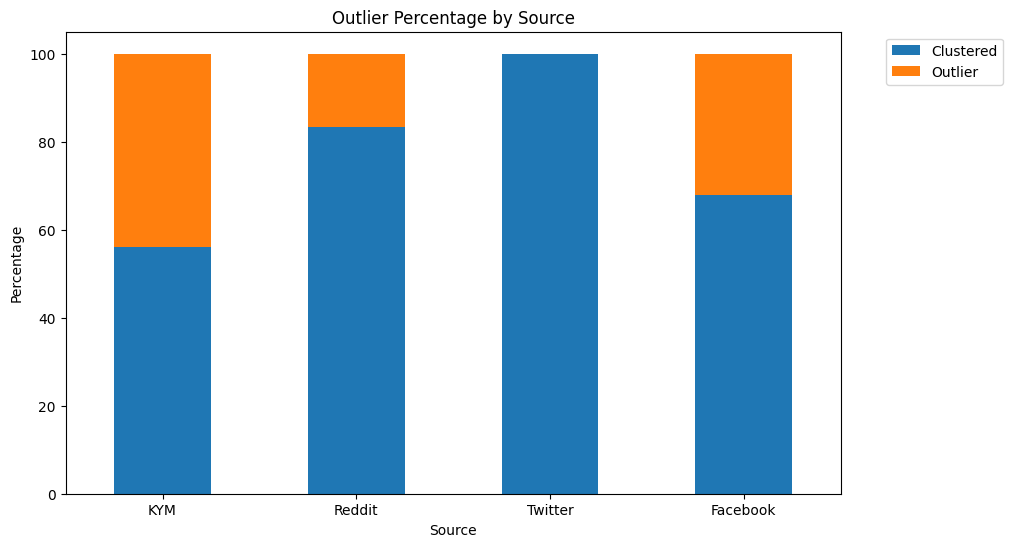

In [51]:
# Get the outliers from data
outliers = data[data['template_cluster'] == -1]

# Get the outliers from reddit (label is nan)
reddit_outliers = outliers[outliers['type'] == 'reddit']
twitter_outliers = outliers[outliers['type'] == 'twitter']
fb_outliers = outliers[outliers['type'] == 'facebook']
kym_outliers = outliers[outliers['type'] == 'kym']

reddit_total = data[data['type'] == 'reddit'].shape[0]
twitter_total = data[data['type'] == 'twitter'].shape[0]
fb_total = data[data['type'] == 'facebook'].shape[0]
kym_total = data[data['type'] == 'kym'].shape[0]


kym_outlier_percentage = kym_outliers.shape[0] / kym_total * 100
reddit_outlier_percentage = reddit_outliers.shape[0] / reddit_total * 100
twitter_outlier_percentage = twitter_outliers.shape[0] / twitter_total * 100
fb_outlier_percentage = fb_outliers.shape[0] / fb_total * 100

kym_clustered_percentage = 100 - kym_outlier_percentage
reddit_clustered_percentage = 100 - reddit_outlier_percentage
twitter_clustered_percentage = 100 - twitter_outlier_percentage
fb_clustered_percentage = 100 - fb_outlier_percentage

# Create a dataframe for barplot
outlier_proportions = pd.DataFrame({
    'Clustered': [kym_clustered_percentage, reddit_clustered_percentage, twitter_clustered_percentage, fb_clustered_percentage],
    'Outlier': [kym_outlier_percentage, reddit_outlier_percentage, twitter_outlier_percentage, fb_outlier_percentage]
}, index=['KYM', 'Reddit', 'Twitter', 'Facebook'])

# Plotting
ax = outlier_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Source')
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.title('Outlier Percentage by Source')
# save as pdf
plt.savefig('./output/outlier_percentage_by_source.pdf', bbox_inches='tight')
plt.show()

In [24]:
def plot_cdf_2(data, xlabel, ylabel, title, legend=None):
    # if data is type Series
    if isinstance(data, pd.Series):
        sorted_data = np.sort(data)
        yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
        # Plot the data with x axis going from 0 to 1
        plt.plot(sorted_data, yvals, marker='.')

        # x ticks should go from 0 to 1 with 0.1 intervals
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, which="both", ls="--")
        plt.show()
    # if data is type list, it means we are plotting multiple CDFs
    elif isinstance(data, list):
        print("Received list of data, plotting multiple CDFs...")
        # Plot the data with x axis going from 0 to 1
        # use colors: orange, lightblue, green
        colors = ['orange', 'lightblue', 'darkblue']
        for i,d in enumerate(data):
            sorted_data = np.sort(d)
            yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
            # plt.plot(sorted_data, yvals, marker='.')
            # use different color for each CDF
            plt.plot(sorted_data, yvals, marker='.', color=colors[i], markersize=4, alpha=.5)
            # marker should be smaller


        # x ticks should go from 0 to 1 with 0.1 intervals
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, which="both", ls="--")
        plt.legend(legend)
        # save the plot as a pdf file
        plt.savefig('./output/image-only/cdf.pdf')
        plt.show()

    

In [3]:
data_wo_outliers = all_inferenced

In [4]:
data_wo_outliers

id  encoded_label  \
0                        bike-is-short-for-bichael_6_1         2325.0   
1            times-virtual-reality-magazine-cover_11_1        20593.0   
2                         cat-whips-it-nae-nae-cat_8_1         3396.0   
3       lamar-roasts-franklin-yee-yee-ass-haircut_16_1        11558.0   
4                            roller-coaster-chess_11_2        16715.0   
...                                                ...            ...   
950133                                    2020_6-43946            NaN   
950134                                    2020_6-43953            NaN   
950135                                    2020_6-43958            NaN   
950136                                    2020_6-43959            NaN   
950137                                    2020_6-43961            NaN   

        predicted_label  template_cluster     type  
0               13411.0               957      kym  
1                3780.0              2988      kym  
2                4004.0                 4      kym  
3               13348.0             13335      kym  
4                3614.0              1228      kym  
...                 ...               ...      ...  
950133          23278.0               536  twitter  
950134          17613.0             12178  twitter  
950135           6076.0             23300  twitter  
950136              NaN             15070  twitter  
950137          16494.0             34721  twitter  

[950138 rows x 5 columns]

Received list of data, plotting multiple CDFs...


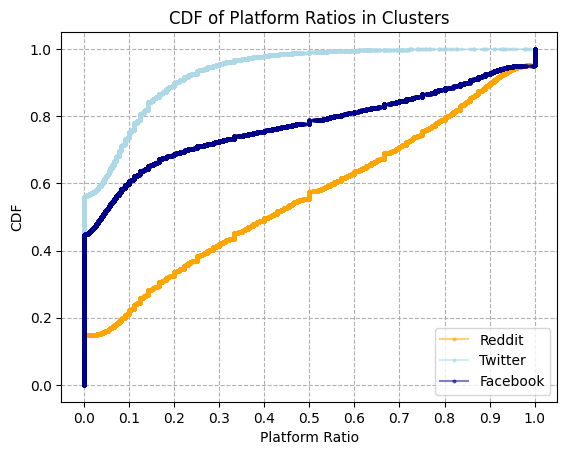

In [25]:
# data_wo_outliers = data[data['template_cluster'] != -1]
cluster_sizes = data_wo_outliers.groupby('template_cluster').size()
# get the reddit count in each cluster using the type=reddit column
reddit_count_in_clusters = data_wo_outliers.groupby('template_cluster')['type'].apply(lambda x: (x == 'reddit').sum())
twitter_count_in_clusters = data_wo_outliers.groupby('template_cluster')['type'].apply(lambda x: (x == 'twitter').sum())
facebook_count_in_clusters = data_wo_outliers.groupby('template_cluster')['type'].apply(lambda x: (x == 'facebook').sum())

# Calculate the ratio of reddit memes in each cluster
reddit_ratio_in_clusters = reddit_count_in_clusters / cluster_sizes
twitter_ratio_in_clusters = twitter_count_in_clusters / cluster_sizes
facebook_ratio_in_clusters = facebook_count_in_clusters / cluster_sizes

# Plot the CDF


plot_cdf_2([reddit_ratio_in_clusters, twitter_ratio_in_clusters, facebook_ratio_in_clusters], 'Platform Ratio', 'CDF', 'CDF of Platform Ratios in Clusters', legend=['Reddit', 'Twitter', 'Facebook'])






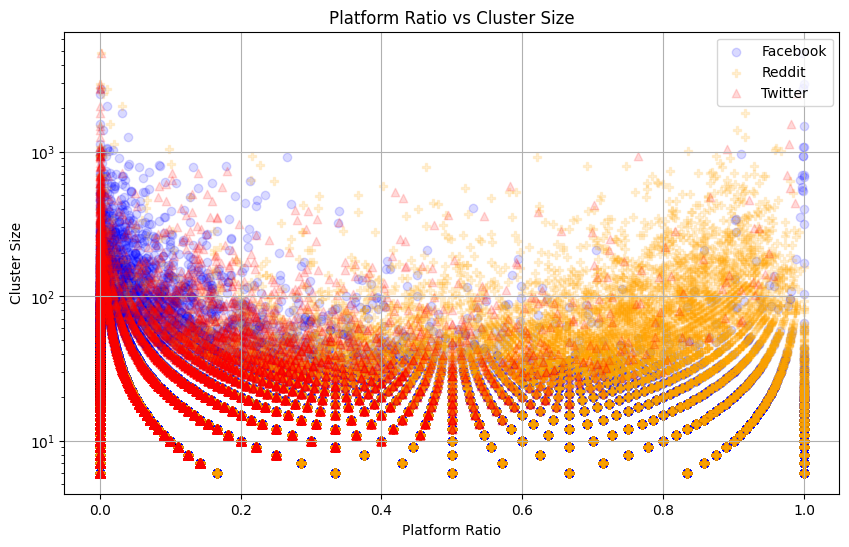

In [46]:
# Scatter plot: x = cluster size, y = reddit ratio
plt.figure(figsize=(10, 6))
plt.scatter(facebook_ratio_in_clusters,cluster_sizes , marker='o', alpha=0.15, c='blue')
plt.scatter(reddit_ratio_in_clusters,cluster_sizes , marker='P', alpha=0.15, c='orange')
plt.scatter(twitter_ratio_in_clusters,cluster_sizes , marker='^', alpha=0.15, c='red')
plt.yscale('log')
plt.ylabel('Cluster Size')
plt.xlabel('Platform Ratio')
plt.title('Platform Ratio vs Cluster Size')
plt.legend(['Facebook', 'Reddit', 'Twitter'], loc='upper right')
plt.grid(True)
# save fig as pdf
plt.savefig('./output/image-only/platform_ratio_vs_cluster_size.pdf')
plt.show()

In [ ]:
# Visualize topics with custom labels
topic_model.visualize_topics(top_n_topics=1000, custom_labels=True)


In [ ]:

# Visualize hierarchy with custom labels
topic_model.visualize_hierarchy(top_n_topics=100, custom_labels=True)


In [ ]:

topic_model.visualize_barchart(top_n_topics=10,custom_labels=True)


In [ ]:

topic_model.visualize_heatmap(top_n_topics=100, custom_labels=True)


In [ ]:

topic_model.visualize_term_rank(custom_labels=True)

## Sanity check!


### Topics per templates

In [ ]:
from bertopic import BERTopic

templates = data["label"]

topics_per_class = topic_model.topics_per_class(text_data, classes=templates)

topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, custom_labels=True)


### Topic count distribution


In [ ]:

counts_and_ids = topic_df[['Count', 'Topic']]
counts_and_ids = counts_and_ids.sort_values(by='Count', ascending=False)
counts_and_ids

In [ ]:

plt.bar(counts_and_ids['Topic'],counts_and_ids['Count'])
plt.show()

### % of majority templates present topics

In [ ]:
# Count rows per encoded_label
counts_and_ids = data[['label', 'id']]
counts_and_ids = counts_and_ids.groupby('label').count()
counts_and_ids = counts_and_ids.rename(columns={'id': 'Count'})
# Get the 75th percentile of the counts
top25 = counts_and_ids[counts_and_ids['Count'] > counts_and_ids['Count'].quantile(0.75)]
top25 = top25.sort_values(by='Count', ascending=False)
top25.reset_index(inplace=True)
counts_and_ids.reset_index(inplace=True)
top25

In [ ]:
represented_labels = top25.loc[top25['label'].isin(topic_df['CustomName'])]['label'].tolist()
print(represented_labels)
top25.loc[top25['label'].isin(topic_df['CustomName'])]

print(f"The top 25% of meme templates are represented in the topics by this percentage: {len(represented_labels)/top25.shape[0]*100.}%")

### Outlier inspection

In [ ]:
outliers = data[data['topic'] == -1]
kym_outliers = outliers[outliers['label'].notna()]
outlier_template_sizes = kym_outliers.groupby('label').size().sort_values(ascending=False)
overall_template_sizes = kym_df.groupby('label').size().sort_values(ascending=False)
outlier_template_sizes.name = 'Outlier Count'
overall_template_sizes.name = 'Overall Count'
# Join the two series on the index
joined_sizes = pd.merge(outlier_template_sizes, overall_template_sizes, how='inner', left_index=True, right_index=True).reset_index()
joined_sizes




In [ ]:
# Set label as index
joined_sizes.set_index('label', inplace=True)

In [ ]:
joined_sizes['Clustered Count'] = joined_sizes['Overall Count'] - joined_sizes['Outlier Count']
joined_sizes

In [ ]:
# Sort the DataFrame based on the outlier proportion
df_sorted = joined_sizes.sort_values('Overall Count', ascending=False)

df_sorted = df_sorted.drop(columns=["Overall Count"], axis=1)
# Pagination parameters
page_size = 20  # Number of templates per page
total_pages = -(-len(df) // page_size)  # Calculate the total number of pages

# Generate paginated plots
for page in range(10):
    start_idx = page * page_size
    end_idx = start_idx + page_size
    df_page = df_sorted.iloc[start_idx:end_idx]
    
    # plt.figure(figsize=(12, 6))
    # bars = plt.bar(df_page['label'],df_page['outlier_proportion'],  color='blue')
    ax = df_page.plot(kind='barh', figsize=(10, 6))
    plt.xlabel('Count')
    plt.ylabel('Template')
    plt.title(f'Proportion of Outliers by Meme Template (Page {page + 1})')
    plt.xticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../BERTopic/figs/proportion-of-outliers/Proportion_Outliers_Page_{page + 1}.png')
    plt.show()


## 11. Use model for inference

In [16]:
twitter = pd.read_parquet("../../data/twitter.parquet")
twitter.shape

(174338, 13)

In [15]:
import numpy as np
import os
from bertopic.backend import MultiModalBackend

if os.path.exists('../../data/twitter_img_embeddings.npy'):
    twitter_img_embeddings = np.load('../../data/twitter_img_embeddings.npy')
else:
    raise Exception("Embeddings not found!")

print(twitter_img_embeddings.shape)

(174338, 512)


In [17]:
def transform(img_embeddings,df):
    try:
        print("Loading BERTopic model...")
        topic_model = BERTopic.load("./output/bertopic_model_fb_reddit")
        print("Reducing dimensions...")
        umap_embeddings = topic_model.umap_model.transform(img_embeddings)
        print("Clustering...")
        preds, _ = hdbscan.approximate_predict(topic_model.hdbscan_model,umap_embeddings)

        df['template_cluster'] = preds

        send_email("BERTopic", "Clustering finished!")
        return df
    except Exception as e:
        send_email("BERTopic - Fail", f"Clustering failed with the following error: {e}")
        raise e
    
twitter = transform(twitter_img_embeddings,twitter)


Loading BERTopic model...
Reducing dimensions...
Clustering...
Message sent!


In [19]:
twitter.to_parquet("../../data/twitter.parquet")

In [ ]:
topic_df

In [ ]:
data_wo_outliers = data[data['topic'] != -1]
template_sizes = data_wo_outliers.groupby('predicted_label').size().sort_values(ascending=False)
template_sizes.name = 'Count'
# Get the index of the first 10
top10 = template_sizes.index[:10]
print(top10)

In [ ]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
docs = data["data"]
categories = data["target"]
category_names = data["target_names"]


In [ ]:
len(data)

In [ ]:
categories.shape

In [ ]:
len(category_names)

In [ ]:
data.groupby(data['encoded_label_x']).count().sort_values(by='id', ascending=False)


In [ ]:
data

In [ ]:
filepaths[0]

In [ ]:
memes['filepath'] = memes['filepath'].apply(lambda x: "\\\\?\\" +os.path.abspath(x))
memes

In [ ]:
os.path.abspath(filepaths[0])

In [ ]:
from tqdm.notebook import tqdm
import os

filepaths = memes.filepath.tolist()

cnt = 0
bad_paths = []
for path in tqdm(filepaths, total=len(filepaths)):
    if not os.path.exists(path):
        cnt += 1
        bad_paths.append(path)

print("Files that cannot be found:", cnt)
print(bad_paths)

In [ ]:
for path in bad_paths:
    print(path)

In [ ]:
dir = "C:/Users/molontay/Murgi/data/Memes2023_splitted_resized/finetuning/train/killing-myself-in-front-of-you-to-forever-change-your-bond-and-the-trajectory-of-your-lives/"

files = os.listdir(dir)
print("This library contains the following files:")
for file in files:
    print(file)

print("These files are allegedly missing:")
for file in files:
    if not os.path.exists(os.path.join(dir, file)):
        print(file)

In [ ]:
longest_path = max(bad_paths, key=len)
print(len(longest_path))

In [ ]:
fixed_path = "\\\\?\\" + os.path.abspath(longest_path)

os.path.exists(fixed_path)


In [ ]:
def get_concat_tile_resize(im_list_2d, image_height=600, image_squares=False):
    """
    Code adapted from: https://note.nkmk.me/en/python-pillow-concat-images/
    """
    images = [[image.copy() for image in images] for images in im_list_2d]
    
    # Create 
    if image_squares:
        width =  int(image_height / 3)
        height = int(image_height / 3)
        images = [[image.resize((width, height)) for image in images] for images in im_list_2d]
    
    # Resize images based on minimum size
    else:
        min_width = min([min([img.width for img in imgs]) for imgs in im_list_2d])
        min_height = min([min([img.height for img in imgs]) for imgs in im_list_2d])
        for i, imgs in enumerate(images):
            for j, img in enumerate(imgs):
                if img.height > img.width:
                    images[i][j] = img.resize((int(img.width * min_height / img.height), min_height), resample=0)
                elif img.width > img.height:
                    images[i][j] = img.resize((min_width, int(img.height * min_width / img.width)), resample=0)
                else:
                    images[i][j] = img.resize((min_width, min_width))

    # Resize grid image
    images = [get_concat_h_multi_resize(im_list_h) for im_list_h in images]
    img = get_concat_v_multi_resize(images)
    height_percentage = (image_height/float(img.size[1]))
    adjusted_width = int((float(img.size[0])*float(height_percentage)))
    img = img.resize((adjusted_width, image_height), Image.Resampling.LANCZOS)
    
    return img


In [ ]:
reddit_images

In [ ]:
corrupted_images = []

for path in tqdm(reddit_images, total= len(reddit_images)):
    img = Image.open(path)
    try:
        if img.height > img.width:
            resized = img.resize((int(img.width * img.height / img.height), img.height), resample=0)
        elif img.width > img.height:
            resized = img.resize((img.width, int(img.height * img.width / img.width)), resample=0)
        else:
            resized = img.resize((img.width, img.width))
    except:
        corrupted_images.append(path)
        continue
    finally:
        img.close()
